[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Komatsu-T/Samples/blob/main/deep_learning/computer_vision/variational_auto_encoder/VQVAE2.ipynb)

# Sample of VQ-VAE2 (only reconstruction)
### Dataset: 13515 images obtained by web scraping
### Reference: https://arxiv.org/abs/1906.00446

### Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import itertools
import os
import shutil
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

### GPU

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

!nvidia-smi

cuda
Wed Aug 14 04:09:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              42W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+--------------------

### Sample data

In [ ]:
%%time
# Copy image file from my google drive to colab current directory
_ = shutil.copy("/content/drive/MyDrive/work/Sample/data/genshin/editted100x100.zip", "/content")

# Unzip
!unzip -qq "/content/editted100x100.zip"

CPU times: user 38.2 ms, sys: 111 ms, total: 149 ms
Wall time: 5.57 s


### Data information

In [ ]:
# --------------------------------------------------
# information
# --------------------------------------------------
image_path = "/content/editted"
class_dirs = os.listdir(image_path)
image_files = [os.listdir(os.path.join(image_path, i)) for i in class_dirs]
sample_image = Image.open(os.path.join(image_path, class_dirs[0], image_files[0][0]))

print(f"No. of classes: {len(class_dirs)}")
print(f"Total no. of images: {np.sum([len(i) for i in image_files])}")
print(f"Image size: {sample_image.size}")
print(f"Minimum no. of images per class: {min([len(i) for i in image_files])}")
print(f"Maximum no. of images per class: {max([len(i) for i in image_files])}")

No. of classes: 82
Total no. of images: 13515
Image size: (100, 100)
Minimum no. of images per class: 20
Maximum no. of images per class: 282


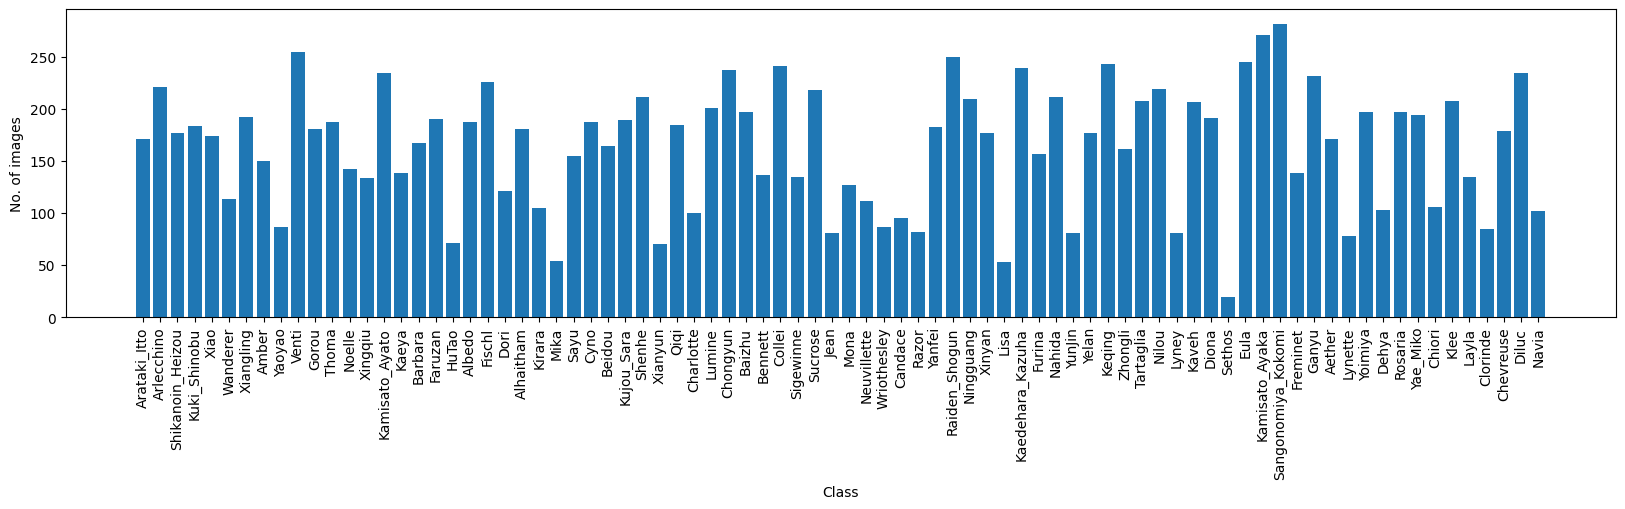

In [ ]:
# --------------------------------------------------
# No. of images per classes
# --------------------------------------------------
plt.figure(figsize = (20, 4))
plt.bar(class_dirs, [len(i) for i in image_files])
plt.xticks(rotation = 90)
plt.xlabel("Class")
plt.ylabel("No. of images")
plt.show()

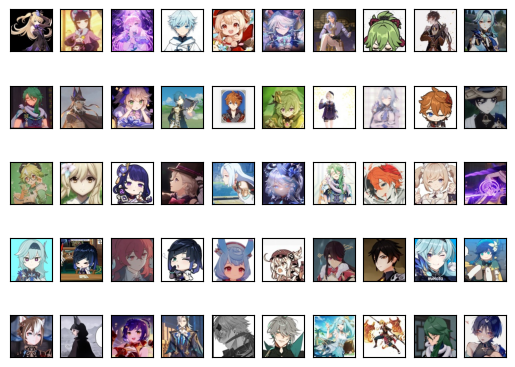

In [ ]:
# --------------------------------------------------
# Show sample images
# --------------------------------------------------
def show_random_image(image_list: list):
    plot_image = np.random.choice(image_list, size = 50, replace = False)
    fig, ax = plt.subplots(5, 10)
    ax = ax.ravel()
    for i, image_path in enumerate(plot_image):
        image = Image.open(image_path)
        ax[i].imshow(image)
        ax[i].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)

image_list = list(itertools.chain.from_iterable([[os.path.join(image_path, d, f) for f in fs] for d, fs in zip(class_dirs, image_files)]))
show_random_image(image_list)

### Train-test split

In [ ]:
# --------------------------------------------------
# Train-test split
# --------------------------------------------------

# Create directory
if os.path.isdir("train"):
    pass
else:
    os.mkdir("train")
    os.mkdir("test")

# Train-test split
test_image_num_per_class = 10
for class_name in class_dirs:

    # Reset & Create directory
    train_path = os.path.join("train", class_name)
    test_path = os.path.join("test", class_name)

    if os.path.isdir(train_path):
        shutil.rmtree(train_path)
        os.mkdir(train_path)
    else:
        os.mkdir(train_path)

    if os.path.isdir(test_path):
        shutil.rmtree(test_path)
        os.mkdir(test_path)
    else:
        os.mkdir(test_path)

    # Random split
    image_list = os.listdir(os.path.join(image_path, class_name))
    test_image_list = np.random.choice(image_list, size = test_image_num_per_class, replace = False)
    train_image_list = [i for i in image_list if i not in test_image_list]

    # Move image to train and test folder
    for image_file_name in test_image_list:
        _ = shutil.move(os.path.join(image_path, class_name, image_file_name), test_path)

    for image_file_name in train_image_list:
        _ = shutil.move(os.path.join(image_path, class_name, image_file_name), train_path)

# Splitted data information
print(f"No. of train images: {np.sum([len(os.listdir(os.path.join('train', i))) for i in os.listdir('train')])}")
print(f"No. of test images: {np.sum([len(os.listdir(os.path.join('test', i))) for i in os.listdir('test')])}")

No. of train images: 12695
No. of test images: 820


### Training

In [ ]:
# --------------------------------------------------
# Data loader
# --------------------------------------------------

# Batch size
batch_size = 128

# Transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [1.0, 1.0, 1.0])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [1.0, 1.0, 1.0])
])

# Dataset
train_dataset = torchvision.datasets.ImageFolder(root = "train", transform = train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = "test", transform = test_transform)

# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
# --------------------------------------------------
# VQ-VAE2 Model
# --------------------------------------------------

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(hidden_channels, in_channels, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        h = torch.relu(x)
        h = self.conv1(h)
        h = torch.relu(h)
        h = self.conv2(h)
        return x + h

class StackedResidualBlock(nn.Module):
    def __init__(self, in_channels, num_residual_layers, hidden_channels):
        super().__init__()
        self.num_residual_layers = num_residual_layers
        self.residual_blocks = nn.ModuleList([ResidualBlock(in_channels, hidden_channels) for _ in range(self.num_residual_layers)])

    def forward(self, x):
        for i in range(self.num_residual_layers):
            x = self.residual_blocks[i](x)
        return torch.relu(x)

class PointwiseConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        return self.conv(x)

class BottomEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_layers, residual_hidden_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels//2, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(out_channels//2, out_channels, kernel_size = 3, stride = 2, padding = 1)
        self.stacked_residula_block = StackedResidualBlock(out_channels, num_residual_layers, residual_hidden_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = torch.relu(out)
        out = self.conv2(out)
        out = torch.relu(out)
        out = self.stacked_residula_block(out)
        return out

class TopEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_layers, residual_hidden_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)
        self.stacked_residula_block = StackedResidualBlock(out_channels, num_residual_layers, residual_hidden_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = torch.relu(out)
        out = self.stacked_residula_block(out)
        return out

class BottomDecoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_residual_layers, residual_hidden_channels, out_channels, crop_size = None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size = 3, stride = 1, padding = 1)
        self.stacked_residula_block = StackedResidualBlock(hidden_channels, num_residual_layers, residual_hidden_channels)
        self.t_conv1 = nn.ConvTranspose2d(hidden_channels, hidden_channels//2, kernel_size = 4, stride = 2, padding = 1)
        self.t_conv2 = nn.ConvTranspose2d(hidden_channels//2, out_channels, kernel_size = 4, stride = 2, padding = 1)
        self.crop_size = crop_size
        if self.crop_size is not None:
            self.cener_crop = transforms.CenterCrop(self.crop_size)

    def forward(self, x):
        out = self.conv1(x)
        out = self.stacked_residula_block(out)
        out = self.t_conv1(out)
        out = torch.relu(out)
        out = self.t_conv2(out)
        if self.crop_size is not None:
            out = self.cener_crop(out)
        out = torch.sigmoid(out)
        return out

class TopDecoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_residual_layers, residual_hidden_channels, out_channels, crop_size = None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size = 3, stride = 1, padding = 1)
        self.stacked_residula_block = StackedResidualBlock(hidden_channels, num_residual_layers, residual_hidden_channels)
        self.t_conv1 = nn.ConvTranspose2d(hidden_channels, out_channels, kernel_size = 4, stride = 2, padding = 1)
        self.crop_size = crop_size
        if self.crop_size is not None:
            self.cener_crop = transforms.CenterCrop(self.crop_size)

    def forward(self, x):
        out = self.conv1(x)
        out = self.stacked_residula_block(out)
        out = self.t_conv1(out)
        if self.crop_size is not None:
            out = self.cener_crop(out)
        out = torch.sigmoid(out)
        return out

class VectorQuantizer(nn.Module):
    def __init__(self, embedding_channels, num_embeddings, beta):
        super().__init__()
        self.embedding_channels = embedding_channels
        self.num_embeddings = num_embeddings
        self.beta = beta
        self.W = nn.Embedding(self.num_embeddings, self.embedding_channels)
        self.W.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, x):
        # NxCxHxW -> NxHxWxC
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.size()
        # Distance
        input_flattened = x.view(-1, self.embedding_channels)
        distances = torch.sum(input_flattened**2, dim = 1, keepdim = True) -2*torch.matmul(input_flattened, self.W.weight.t()) + torch.sum(self.W.weight**2, dim = 1)
        encoding_indices = torch.argmin(distances, 1).unsqueeze(1)
        # To onehot vector
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device = x.device)
        encodings.scatter_(1, encoding_indices, 1)
        # Quantize
        quantized = torch.matmul(encodings, self.W.weight)
        quantized = quantized.view(input_shape)
        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized.detach(), x)
        embedding_loss = F.mse_loss(quantized, x.detach())
        vq_loss = commitment_loss*self.beta + embedding_loss
        # Straight-Through Estimator
        quantized = x + (quantized - x).detach()
        return quantized.permute(0, 3, 1, 2).contiguous(), vq_loss

class VQVAE2(nn.Module):
    def __init__(
            self,
            bottom_encoder: BottomEncoder,
            top_encoder: TopEncoder,
            bottom_pointwise_conv: PointwiseConv,
            top_pointwise_conv: PointwiseConv,
            top_vector_quantizer: VectorQuantizer,
            bottom_vector_quantizer: VectorQuantizer,
            top_decoder: TopDecoder,
            bottom_decoder: BottomDecoder,
            train_data_variance: float,
    ):
        super().__init__()
        self.bottom_encoder = bottom_encoder
        self.top_encoder = top_encoder
        self.bottom_pointwise_conv = bottom_pointwise_conv
        self.top_pointwise_conv = top_pointwise_conv
        self.top_vector_quantizer = top_vector_quantizer
        self.bottom_vector_quantizer = bottom_vector_quantizer
        self.top_decoder = top_decoder
        self.bottom_decoder = bottom_decoder
        self.train_data_variance = train_data_variance

    def forward(self, x):
        # Encode
        bottom_map = self.bottom_encoder(x)
        top_map = self.top_encoder(bottom_map)
        # Top quantize
        quantized_top_map, top_vq_loss = self.top_vector_quantizer(self.top_pointwise_conv(top_map))
        # Bottom quantize
        decoded_top_map = self.top_decoder(quantized_top_map)
        quantized_bottom_map, bottom_vq_loss = self.bottom_vector_quantizer(self.bottom_pointwise_conv(torch.cat([bottom_map, decoded_top_map], dim = 1)))
        # Decode
        reconstructed_x = self.bottom_decoder(torch.cat([quantized_bottom_map, decoded_top_map], dim = 1))
        # Compute losses
        reconstruction_loss = F.mse_loss(reconstructed_x, x)/self.train_data_variance
        #reconstruction_loss = F.binary_cross_entropy(reconstructed_x, x, reduction = 'sum')
        loss = reconstruction_loss + top_vq_loss + bottom_vq_loss
        return reconstructed_x, quantized_top_map, quantized_bottom_map, loss

In [ ]:
# --------------------------------------------------
# Model instantiation
# --------------------------------------------------

# Model parameter
INPUT_CHANNEL = 3

BOTTOM_ENCODER_OUTPUT_CHANNEL = 128
TOP_ENCODER_OUTPUT_CHANNEL = 256

NUM_RESIDUAL_LAYERS = 4
RESIDUAL_HIDDEN_CHANNELS = 128

BOTTOM_EMBEDDING_CHANNEL = 64
BOTTOM_NUM_EMBEDDING = 512
BOTTOM_BETA = 0.25

TOP_EMBEDDING_CHANNEL = 64
TOP_NUM_EMBEDDING = 512
TOP_BETA = 0.25

TOP_DECODER_OUTPUT_CHANNEL = 128
TOP_DECODER_HIDDEN_CHANNEL = 128
TOP_DECODER_CROP = 25

BOTTOM_DECODER_HIDDEN_CHANNEL = 128

TRAIN_DATA_VARIANCE = 1.0

# Model
bottom_encoder = BottomEncoder(INPUT_CHANNEL, BOTTOM_ENCODER_OUTPUT_CHANNEL, NUM_RESIDUAL_LAYERS, RESIDUAL_HIDDEN_CHANNELS)
top_encoder = TopEncoder(BOTTOM_ENCODER_OUTPUT_CHANNEL, TOP_ENCODER_OUTPUT_CHANNEL, NUM_RESIDUAL_LAYERS, RESIDUAL_HIDDEN_CHANNELS)

top_pointwise_conv = PointwiseConv(TOP_ENCODER_OUTPUT_CHANNEL, TOP_EMBEDDING_CHANNEL)
bottom_pointwise_conv = PointwiseConv(BOTTOM_ENCODER_OUTPUT_CHANNEL+TOP_DECODER_OUTPUT_CHANNEL, BOTTOM_EMBEDDING_CHANNEL)

top_vector_quantizer = VectorQuantizer(TOP_EMBEDDING_CHANNEL, TOP_NUM_EMBEDDING, TOP_BETA)
bottom_vector_quantizer = VectorQuantizer(BOTTOM_EMBEDDING_CHANNEL, BOTTOM_NUM_EMBEDDING, BOTTOM_BETA)

top_decoder = TopDecoder(TOP_EMBEDDING_CHANNEL, TOP_DECODER_HIDDEN_CHANNEL, NUM_RESIDUAL_LAYERS, RESIDUAL_HIDDEN_CHANNELS, TOP_DECODER_OUTPUT_CHANNEL, TOP_DECODER_CROP)
bottom_decoder = BottomDecoder(TOP_DECODER_OUTPUT_CHANNEL+BOTTOM_EMBEDDING_CHANNEL, BOTTOM_DECODER_HIDDEN_CHANNEL, NUM_RESIDUAL_LAYERS, RESIDUAL_HIDDEN_CHANNELS, INPUT_CHANNEL)

model = VQVAE2(
    bottom_encoder = bottom_encoder,
    top_encoder = top_encoder,
    bottom_pointwise_conv = bottom_pointwise_conv,
    top_pointwise_conv = top_pointwise_conv,
    bottom_vector_quantizer = bottom_vector_quantizer,
    top_vector_quantizer = top_vector_quantizer,
    top_decoder = top_decoder,
    bottom_decoder = bottom_decoder,
    train_data_variance = TRAIN_DATA_VARIANCE,
)
model = model.to(device)

In [ ]:
# --------------------------------------------------
# Optimizer
# --------------------------------------------------

lr = 3e-4
weight_decay = 0
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

100%|██████████| 800/800 [4:27:11<00:00, 20.04s/it]


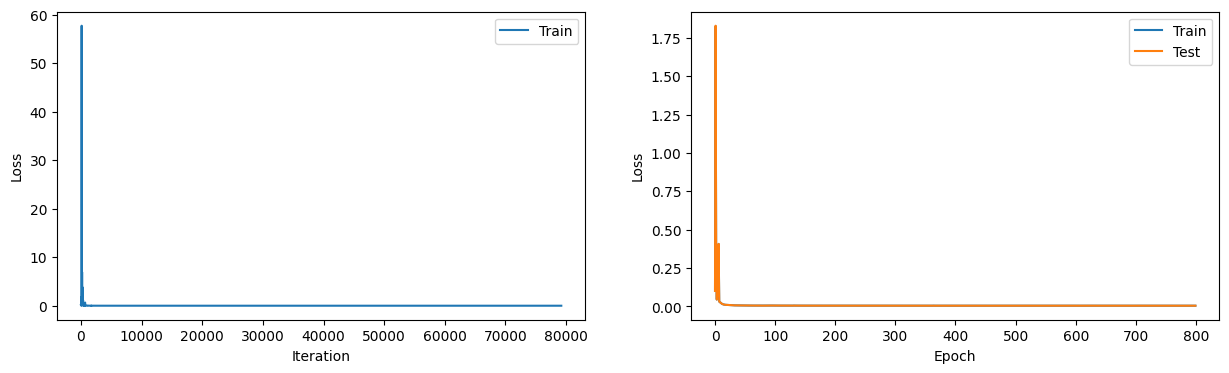

In [ ]:
# --------------------------------------------------
# Training
# --------------------------------------------------

# Settings
epochs = 800
train_loss_minibatch = []
train_loss_epoch = []
test_loss_epoch = []

# Training
for epoch in tqdm(range(epochs)):

    # Traininig step
    model.train()
    for x, _ in train_loader:
        x = x.to(device)
        reconstructed_x, quantized_top_map, quantized_bottom_map, loss = model(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_minibatch.append(loss.item())

    # Evaluation step
    model.eval()
    with torch.no_grad():
        # Train loss
        losses = []
        for x, _ in train_loader:
            x = x.to(device)
            _, _, _, loss = model(x)
            losses.append(loss.item())
        train_loss_epoch.append(np.mean(losses))

        # Test loss
        losses = []
        for x, _ in test_loader:
            x = x.to(device)
            _, _, _, loss = model(x)
            losses.append(loss.item())
        test_loss_epoch.append(np.mean(losses))

# Loss plot
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].plot(train_loss_minibatch, label = 'Train')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(train_loss_epoch, label = "Train")
ax[1].plot(test_loss_epoch, label = "Test")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()
plt.show()

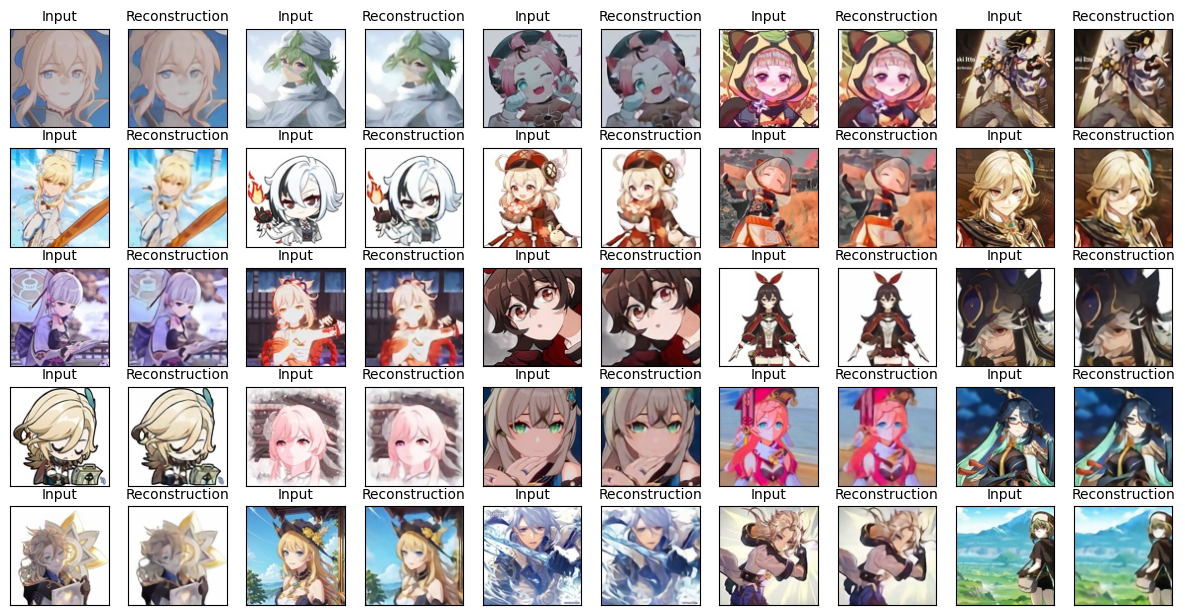

In [ ]:
# --------------------------------------------------
# Show reconstructed image (train)
# --------------------------------------------------

class InverseNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, input):
        for t, m, s in zip(input, self.mean, self.std):
            t.mul_(s).add_(m)
        return input

def compare_reconstruction_image(model, dataset, InverseNormalize):
    inverse_normalize = InverseNormalize(mean = [0.5, 0.5, 0.5], std = [1.0, 1.0, 1.0])
    image_num = len(dataset)
    plot_image_index = np.random.choice([i for i in range(image_num)], size = 25, replace = False)
    fig, ax = plt.subplots(5, 10, figsize = (15, 7.5))
    ax = ax.ravel()
    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(plot_image_index):
            input = train_dataset[idx][0].to(device)
            input_size = input.size()
            reconstrunted_input, _, _, _ = model(input.view(1, input_size[0], input_size[1], input_size[2]))

            ax[i*2].imshow(input.permute(1, 2, 0).cpu())
            ax[i*2+1].imshow(np.clip(reconstrunted_input[0].permute(1, 2, 0).cpu(), 0, 1))
            ax[i*2].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
            ax[i*2+1].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
            ax[i*2].set_title("Input", fontsize = 10)
            ax[i*2+1].set_title("Reconstruction", fontsize = 10)

# Show image
compare_reconstruction_image(model, train_dataset, InverseNormalize)

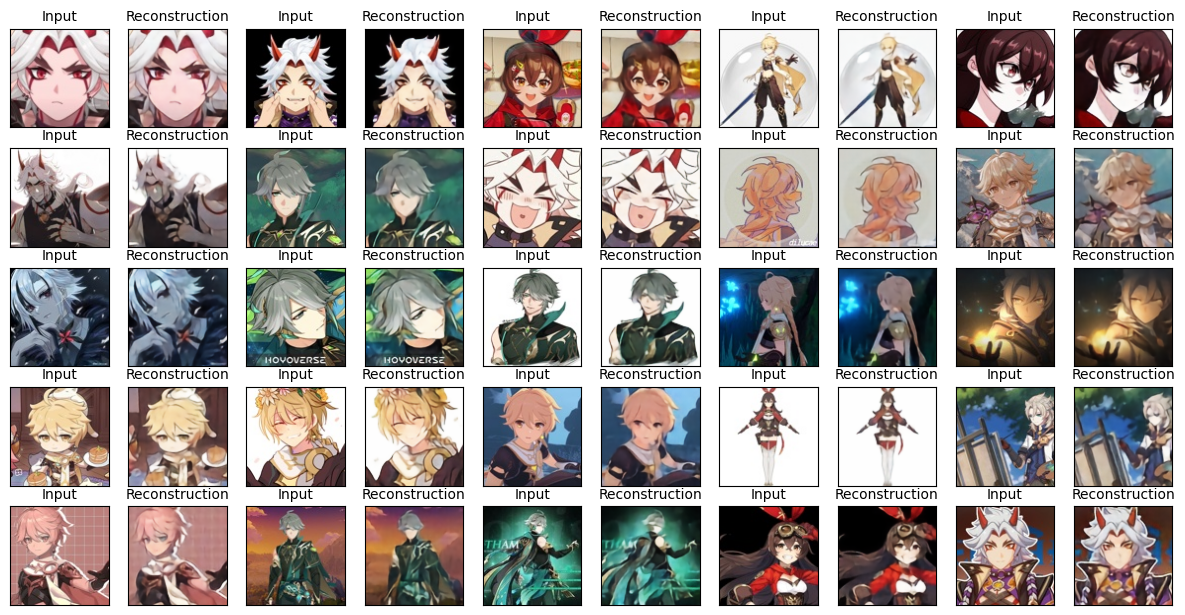

In [ ]:
# --------------------------------------------------
# Show reconstructed image (test)
# --------------------------------------------------

# Show image
compare_reconstruction_image(model, test_dataset, InverseNormalize)